In [1]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Please change to path to your mml folder on google drive 
path ="/content/drive/My Drive/mml/"
#path ="/content/drive/My Drive/Colab Notebooks/mml/"
path_to_pyera = path + "pyERA-master"

In [3]:
import os
os.chdir(path_to_pyera)
!python setup.py install

/usr/lib/python3.6/distutils/dist.py:261: UserWarning: Unknown distribution option: 'include_package_data'
  warnings.warn(msg)
running install
running build
running build_py
file pyERA.py (for module pyERA) not found
file pyERA.py (for module pyERA) not found
running install_lib
creating /usr/local/lib/python3.6/dist-packages/pyERA
copying build/lib/pyERA/__init__.py -> /usr/local/lib/python3.6/dist-packages/pyERA
copying build/lib/pyERA/utils.py -> /usr/local/lib/python3.6/dist-packages/pyERA
copying build/lib/pyERA/tfsom.py -> /usr/local/lib/python3.6/dist-packages/pyERA
copying build/lib/pyERA/hebbian.py -> /usr/local/lib/python3.6/dist-packages/pyERA
copying build/lib/pyERA/som.py -> /usr/local/lib/python3.6/dist-packages/pyERA
byte-compiling /usr/local/lib/python3.6/dist-packages/pyERA/__init__.py to __init__.cpython-36.pyc
byte-compiling /usr/local/lib/python3.6/dist-packages/pyERA/utils.py to utils.cpython-36.pyc
byte-compiling /usr/local/lib/python3.6/dist-packages/pyERA/tfsom

In [4]:
import numpy as np
import pandas as pd
#It requires the pyERA library

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from pyERA.som import Som
from pyERA.utils import ExponentialDecay
from pyERA.hebbian import HebbianNetwork

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import imshow
from PIL import Image
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm


os.chdir(path)
from som_functions import testSOM, plotJoints, plotVisual, testSomHubPass, plotSom, get_SDH, get_activation_histogram

In [5]:
train = loadmat(path + "training_data/final_database_train.mat")
test = loadmat(path + "training_data/final_database_test.mat")
train = train["final_database_train"]
test = test["final_database_test"]
scaler = StandardScaler()

proprio = scaler.fit_transform(train[:,28:32])
visual = scaler.fit_transform(train[:,36:40])
tactil = train[:,44]
sound = train[:,46]
velocity = scaler.fit_transform(train[:,48:52])
#train_data = np.concatenate([proprio, visual, tactil, sound, velocity], axis=1)

proprio_test = scaler.fit_transform(test[:, :4])
visual_test = scaler.fit_transform(test[:,8:12])
tactil_test = test[:,16]
sound_test = test[:,18]
velocity_test = scaler.fit_transform(test[:,20:24])


sound = scaler.fit_transform(np.reshape(sound, (sound.shape[0], 1)))
sound_test = scaler.fit_transform(np.reshape(sound_test, (sound_test.shape[0], 1)))
tactil = scaler.fit_transform(np.reshape(tactil, (tactil.shape[0], 1)))
tactil_test = scaler.fit_transform(np.reshape(tactil_test, (tactil_test.shape[0], 1)))

print(len(test))

1487


In [6]:
som_size = 10
hub_som = Som(matrix_size=som_size, input_size=10)
proprio_som= Som(matrix_size=som_size, input_size= len(proprio[0]))
visual_som = Som(matrix_size=som_size, input_size= len(visual[0]))
tactil_som = Som(matrix_size=som_size, input_size= 1)
sound_som = Som(matrix_size=som_size, input_size= 1)
velocity_som = Som(matrix_size=som_size, input_size= len(velocity[0]))


hebbian_network = HebbianNetwork("net")
hebbian_network.add_node("hub_som", (som_size, som_size))
hebbian_network.add_node("proprio_som", (som_size, som_size))
hebbian_network.add_node("visual_som", (som_size, som_size))
hebbian_network.add_node("tactil_som", (som_size, som_size))
hebbian_network.add_node("sound_som", (som_size, som_size))
hebbian_network.add_node("velocity_som", (som_size, som_size))
hebbian_network.add_connection(1, 0)
hebbian_network.add_connection(2, 0)
hebbian_network.add_connection(3, 0)
hebbian_network.add_connection(4, 0)
hebbian_network.add_connection(5, 0)

hebbian_network.print_info()


Net Name ..... net
Total Nodes ..... 6
Total Connections ..... 5
Nodes Name: 
hub_som;
proprio_som;
visual_som;
tactil_som;
sound_som;
velocity_som;



In [ ]:
tot_epoch = 1
my_learning_rate = ExponentialDecay(starter_value=0.5, decay_step=tot_epoch * len(train)/ 5, decay_rate=0.9, staircase=True)
my_radius = ExponentialDecay(starter_value=np.rint(som_size / 3), decay_step=tot_epoch * len(train)/ 6, decay_rate=0.90,
							 staircase=True)

print("Training starts.")
for epoch in range(1, tot_epoch+1):
	for sample in range(1, len(train)):

		learning_rate = my_learning_rate.return_decayed_value(global_step=(epoch-1) * len(train) + sample)
		radius = my_radius.return_decayed_value(global_step=(epoch-1) * len(train) + sample)

		# Training the Proprio SOM
		input_vector = proprio[sample]
		p_bmu_index = proprio_som.return_BMU_index_cosine(input_vector)
		p_bmu_weights = proprio_som.get_unit_weights(p_bmu_index[0], p_bmu_index[1])
		bmu_neighborhood_list = proprio_som.return_unit_round_neighborhood(p_bmu_index[0], p_bmu_index[1], radius=radius)
		proprio_activation_matrix = proprio_som.return_activation_matrix(input_vector)
		proprio_som.training_single_step(input_vector, units_list=bmu_neighborhood_list, learning_rate=learning_rate, radius=radius, weighted_distance=False)
	
		# Training the visual SOM
		input_vector = visual[sample]
		v_bmu_index = visual_som.return_BMU_index(input_vector)
		v_bmu_weights = visual_som.get_unit_weights(v_bmu_index[0], v_bmu_index[1])
		bmu_neighborhood_list = visual_som.return_unit_round_neighborhood(v_bmu_index[0], v_bmu_index[1], radius=radius)
		visual_activation_matrix = visual_som.return_activation_matrix(input_vector)
		visual_som.training_single_step(input_vector, units_list=bmu_neighborhood_list, learning_rate=learning_rate, radius=radius, weighted_distance=False)

		# Training the tactil SOM
		input_vector = tactil[sample]
		t_bmu_index = tactil_som.return_BMU_index(input_vector)
		t_bmu_weights = tactil_som.get_unit_weights(t_bmu_index[0], t_bmu_index[1])
		bmu_neighborhood_list = tactil_som.return_unit_round_neighborhood(t_bmu_index[0], t_bmu_index[1], radius=radius)
		tactil_activation_matrix = tactil_som.return_activation_matrix(input_vector)
		tactil_som.training_single_step(input_vector, units_list=bmu_neighborhood_list, learning_rate=learning_rate, radius=radius, weighted_distance=False)		

		# Training the sound SOM
		input_vector = sound[sample]
		s_bmu_index = sound_som.return_BMU_index(input_vector)
		s_bmu_weights = sound_som.get_unit_weights(s_bmu_index[0], s_bmu_index[1])
		bmu_neighborhood_list = sound_som.return_unit_round_neighborhood(s_bmu_index[0], s_bmu_index[1], radius=radius)
		sound_activation_matrix = sound_som.return_activation_matrix(input_vector)
		sound_som.training_single_step(input_vector, units_list=bmu_neighborhood_list, learning_rate=learning_rate, radius=radius, weighted_distance=False)	
	
		# Training the velocity SOM
		input_vector = velocity[sample]
		vel_bmu_index = velocity_som.return_BMU_index(input_vector)
		bmu_weights = velocity_som.get_unit_weights(vel_bmu_index[0], vel_bmu_index[1])
		bmu_neighborhood_list = velocity_som.return_unit_round_neighborhood(vel_bmu_index[0], vel_bmu_index[1], radius=radius)
		velocity_activation_matrix = velocity_som.return_activation_matrix(input_vector)
		velocity_som.training_single_step(input_vector, units_list=bmu_neighborhood_list, learning_rate=learning_rate, radius=radius, weighted_distance=False)

		#Training the Hub SOM
		input_vector = np.array([p_bmu_index[0], p_bmu_index[1], v_bmu_index[0], v_bmu_index[1], t_bmu_index[0], t_bmu_index[1], s_bmu_index[0], s_bmu_index[1], vel_bmu_index[0], vel_bmu_index[1]])
		bmu_index = hub_som.return_BMU_index(input_vector)
		bmu_weights = hub_som.get_unit_weights(bmu_index[0], bmu_index[1])
		bmu_neighborhood_list = hub_som.return_unit_round_neighborhood(bmu_index[0], bmu_index[1], radius=radius)
		hub_activation_matrix = hub_som.return_activation_matrix(input_vector)
		hub_som.training_single_step(input_vector, units_list=bmu_neighborhood_list, learning_rate=learning_rate,
                                         radius=radius, weighted_distance=False)	

		# Hebbian Learning
		hebbian_network.set_node_activations(0, hub_activation_matrix)
		hebbian_network.set_node_activations(1, proprio_activation_matrix)
		hebbian_network.set_node_activations(2, visual_activation_matrix)
		hebbian_network.set_node_activations(3, tactil_activation_matrix)
		hebbian_network.set_node_activations(4, sound_activation_matrix)
		hebbian_network.set_node_activations(5, velocity_activation_matrix)
		hebbian_network.learning(learning_rate=0.01, rule="hebb")

print("Training is done.")

Training starts.


In [ ]:
hub_input = []
for i  in range(N_test):
  p_bmu_index = proprio_som.return_BMU_index(test_joints[i])
  v_bmu_index = visual_som.return_BMU_index(test_topCam[i])
  t_bmu_index = tactil_som.return_BMU_index(test_botCam[i])
  s_bmu_index = sound_som.return_BMU_index(test_botCam[i])
  vel_bmu_index = velocity_som.return_BMU_index(test_botCam[i])
  input_vector = np.array([p_bmu_index[0], p_bmu_index[1], v_bmu_index[0], v_bmu_index[1], t_bmu_index[0], t_bmu_index[1],  s_bmu_index[0], s_bmu_index[1],  vel_bmu_index[0], vel_bmu_index[1]])
  hub_input.append(input_vector)
  print(str(i) + "  " + str(input_vector))

In [ ]:
test_len = 100

out_pv, mse_mean_pv, mse_std_pv = testSomHubPass(visual_som, hub_som, proprio_som, 2, 0, 1, hebbian_network, test_len, visual_test, proprio_test)
out_vp, mse_mean_vp, mse_std_vp = testSomHubPass(proprio_som, hub_som, visual_som , 1, 0, 2, hebbian_network, test_len, proprio_test, visual_test)

out_pvel, mse_mean_pvel, mse_std_pvel = testSomHubPass(velocity_som, hub_som, proprio_som, 2, 0, 1, hebbian_network, test_len, velocity_test, proprio_test)
out_velp, mse_mean_velp, mse_std_velp = testSomHubPass(proprio_som, hub_som, velocity_som , 1, 0, 2, hebbian_network, test_len, proprio_test, velocity_test)

out_pt, mse_mean_pt, mse_std_pt = testSomHubPass(tactil_som, hub_som, proprio_som, 2, 0, 1, hebbian_network, test_len, tactil_test, proprio_test)
out_tp, mse_mean_tp, mse_std_tp = testSomHubPass(proprio_som, hub_som, tactil_som , 1, 0, 2, hebbian_network, test_len, proprio_test, tactil_test)

out_ps, mse_mean_ps, mse_std_ps = testSomHubPass(sound_som, hub_som, proprio_som, 2, 0, 1, hebbian_network, test_len, sound_test, proprio_test)
out_sp, mse_mean_sp, mse_std_sp = testSomHubPass(proprio_som, hub_som, sound_som , 1, 0, 2, hebbian_network, test_len, proprio_test, sound_test)

out_vvel, mse_mean_vvel, mse_std_vvel = testSomHubPass(velocity_som, hub_som, visual_som, 2, 0, 1, hebbian_network, test_len, velocity_test, visual_test)
out_velv, mse_mean_velv, mse_std_velv = testSomHubPass(visual_som, hub_som, velocity_som , 1, 0, 2, hebbian_network, test_len, visual_test, velocity_test)

out_vt, mse_mean_vt, mse_std_vt = testSomHubPass(tactil_som, hub_som, visual_som, 2, 0, 1, hebbian_network, test_len, tactil_test, visual_test)
out_tv, mse_mean_tv, mse_std_tv = testSomHubPass(visual_som, hub_som, tactil_som , 1, 0, 2, hebbian_network, test_len, visual_test, tactil_test)


out_vs, mse_mean_vs, mse_std_vs = testSomHubPass(sound_som, hub_som, visual_som, 2, 0, 1, hebbian_network, test_len, sound_test, visual_test)
out_sv, mse_mean_sv, mse_std_sv = testSomHubPass(visual_som, hub_som, sound_som , 1, 0, 2, hebbian_network, test_len, visual_test, sound_test)

out_velt, mse_mean_velt, mse_std_velt = testSomHubPass(tactil_som, hub_som, velocity_som, 2, 0, 1, hebbian_network, test_len, tactil_test, velocity_test)
out_tvel, mse_mean_tvel, mse_std_tvel = testSomHubPass(velocity_som, hub_som, tactil_som , 1, 0, 2, hebbian_network, test_len, velocity_test, tactil_test)

out_vels, mse_mean_vels, mse_std_vels = testSomHubPass(sound_som, hub_som, velocity_som, 2, 0, 1, hebbian_network, test_len, sound_test, velocity_test)
out_svel, mse_mean_svel, mse_std_svel = testSomHubPass(velocity_som, hub_som, sound_som , 1, 0, 2, hebbian_network, test_len, velocity_test, sound_test)


out_st, mse_mean_st, mse_std_st = testSomHubPass(tactil_som, hub_som, sound_som, 2, 0, 1, hebbian_network, test_len, tactil_test, sound_test)
out_ts, mse_mean_ts, mse_std_ts = testSomHubPass(sound_som, hub_som, tactil_som , 1, 0, 2, hebbian_network, test_len, sound_test, tactil_test)


In [ ]:
names = ["proprio", "visual", "sound", "tactil", "velocity" ]
mean_p = [0, mse_mean_pv, mse_mean_ps, mse_mean_pt, mse_mean_pvel]
mean_v = [mse_mean_vp, 0 , mse_mean_vs, mse_mean_vt, mse_mean_vvel]
mean_s = [mse_mean_sp, mse_mean_sv , 0, mse_mean_st, mse_mean_svel]
mean_t = [mse_mean_tp, mse_mean_tv , mse_mean_ts, 0, mse_mean_tvel]
mean_vel = [mse_mean_velp, mse_mean_velv , mse_mean_vels, mse_mean_velt, 0]

mean_p = [np.round(i,5) for i in mean_p]
mean_v = [np.round(i,5) for i in mean_v]
mean_s = [np.round(i,5) for i in mean_s]
mean_t = [np.round(i,5) for i in mean_t]
mean_vel= [np.round(i,5) for i in mean_vel]

mean_results = {'modalities': names,
        'proprio': mean_p,
        'visual': mean_v,
        'sound': mean_s,
        'tactil': mean_t,
        'velocity' : mean_vel,
        }

mean = pd.DataFrame (mean_results, columns = ['modalities', "proprio", "visual", "sound", "tactil", "velocity" ])

std_p = [0, mse_std_pv, mse_std_ps, mse_std_pt, mse_std_pvel]
std_v = [mse_std_vp, 0 , mse_std_vs, mse_std_vt, mse_std_vvel]
std_s = [mse_std_sp, mse_std_sv , 0, mse_std_st, mse_std_svel]
std_t = [mse_std_tp, mse_std_tv , mse_std_ts, 0, mse_std_tvel]
std_vel = [mse_std_velp, mse_std_velv , mse_std_vels, mse_std_velt, 0]

std_p = [np.round(i,5) for i in std_p]
std_v = [np.round(i,5) for i in std_v]
std_s = [np.round(i,5) for i in std_s]
std_t = [np.round(i,5) for i in std_t]
std_vel= [np.round(i,5) for i in std_vel]

std_results = {'modalities': names,
        'proprio': std_p,
        'visual': std_v,
        'sound': std_s,
        'tactil': std_t,
        'velocity' : std_vel,
        }

std = pd.DataFrame (std_results, columns = ['modalities', "proprio", "visual", "sound", "tactil", "velocity" ])

mean.to_csv('mean_2.csv', sep=',', index=False)
std.to_csv('std_2.csv', sep=',', index=False)

print("Mean Square Error for all models")
print(mean)
print(" ")
print("Mean Standart Deviation for all models")
print(std)

  modalities proprio visual sound tactil velocity
0       None    None   None  None   None     None
1       None    None   None  None   None     None
2       None    None   None  None   None     None
3       None    None   None  None   None     None
4       None    None   None  None   None     None
5       None    None   None  None   None     None


NameError: ignored

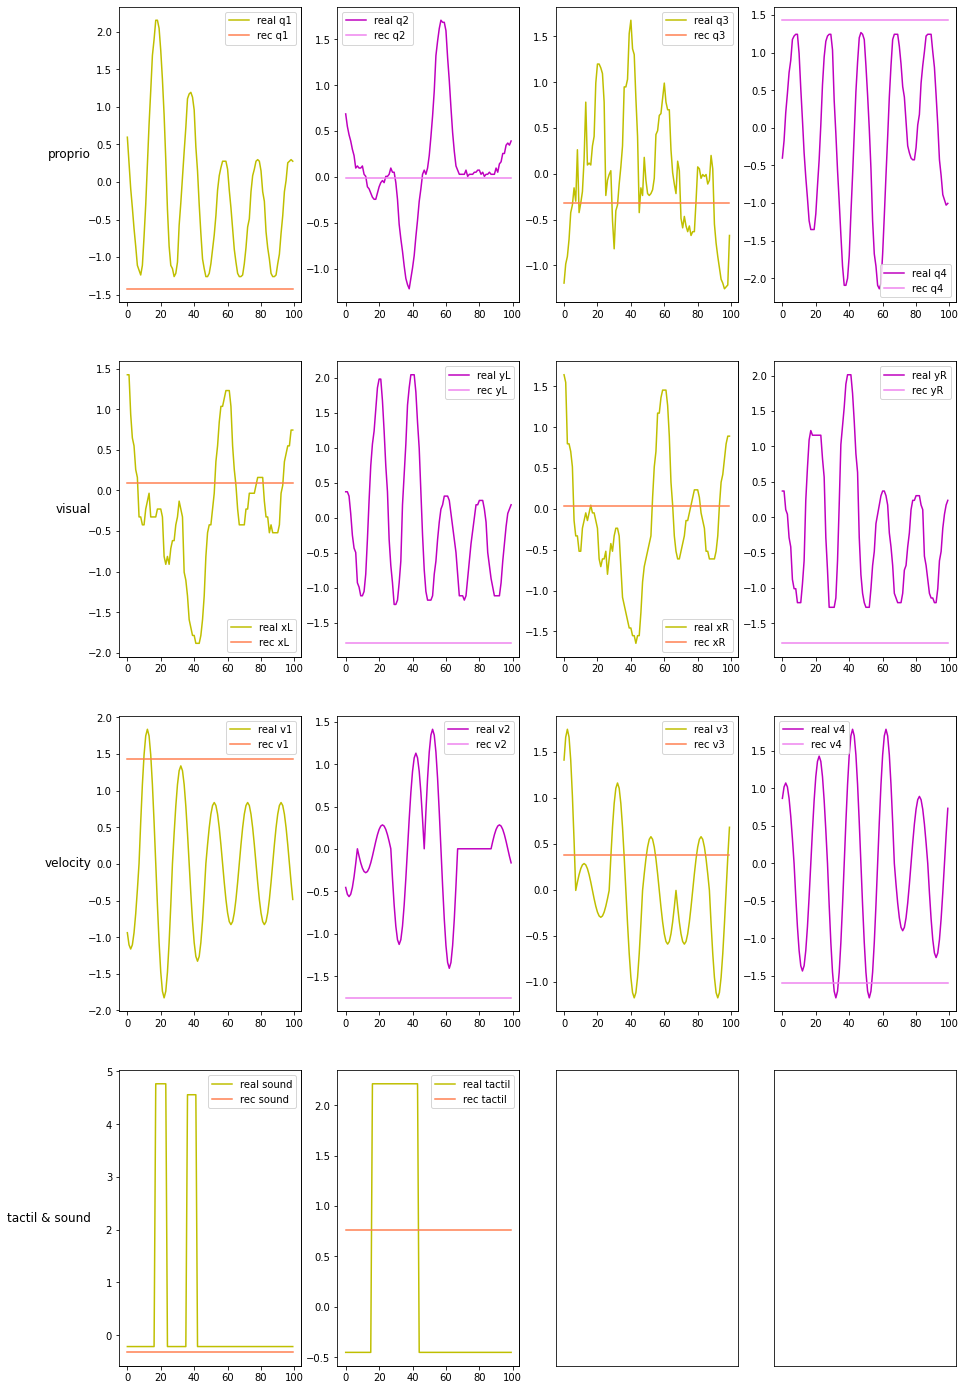

In [ ]:
f, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 25))

rows = ["proprio", "visual", "velocity", "tactil & sound"]
pad = 20
out_velv = np.array(out_velv)
out_vp = np.array(out_vp)
out_pv = np.array(out_pv)
velocity_test=velocity_test[:test_len]
visual_test=visual_test[:test_len]
proprio_test=proprio_test[:test_len]
tactil_test=tactil_test[:test_len]
sound_test=sound_test[:test_len]

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);


vel1, vel2, vel3, vel4 = velocity_test[:,0], velocity_test[:,1],  velocity_test[:,2], velocity_test[:,3]
vel_o1, vel_o2, vel_o3, vel_o4  = out_velv[:,0], out_velv[:,1], out_velv[:,2], out_velv[:,3] 

v1, v2, v3, v4 = visual_test[:,0], visual_test[:,1],  visual_test[:,2], visual_test[:,3]
v_o1, v_o2, v_o3, v_o4  = out_vp[:,0], out_vp[:,1], out_vp[:,2], out_vp[:,3] 

p1, p2, p3, p4 = proprio_test[:,0], proprio_test[:,1],  proprio_test[:,2], proprio_test[:,3]
p_o1, p_o2, p_o3, p_o4  = out_pv[:,0], out_pv[:,1], out_pv[:,2], out_pv[:,3] 

f.add_subplot(4, 4, 1)   
plt.plot(p1, 'y', label="real q1")
plt.plot(p_o1, color='coral', label="rec q1")
plt.legend()

f.add_subplot(4, 4, 2)
plt.plot(p2, 'm', label="real q2")
plt.plot(p_o2, color='violet', label="rec q2")
plt.legend()

f.add_subplot(4, 4, 3)   
plt.plot(p3, 'y', label="real q3")
plt.plot(p_o3, color='coral', label="rec q3")
plt.legend()

f.add_subplot(4, 4, 4)
plt.plot(p4, 'm', label="real q4")
plt.plot(p_o4, color='violet', label="rec q4")
plt.legend()

f.add_subplot(4, 4, 5)   
plt.plot(v1, 'y', label="real xL")
plt.plot(v_o1, color='coral', label="rec xL")
plt.legend()

f.add_subplot(4, 4, 6)
plt.plot(v2, 'm', label="real yL")
plt.plot(v_o2, color='violet', label="rec yL")
plt.legend()

f.add_subplot(4, 4, 7)   
plt.plot(v3, 'y', label="real xR")
plt.plot(v_o3, color='coral', label="rec xR")
plt.legend()

f.add_subplot(4, 4, 8)
plt.plot(v4, 'm', label="real yR")
plt.plot(v_o4, color='violet', label="rec yR")
plt.legend()


f.add_subplot(4, 4, 9)   
plt.plot(vel1, 'y', label="real v1")
plt.plot(vel_o1, color='coral', label="rec v1")
plt.legend()

f.add_subplot(4, 4, 10)
plt.plot(vel2, 'm', label="real v2")
plt.plot(vel_o2, color='violet', label="rec v2")
plt.legend()

f.add_subplot(4, 4, 11)   
plt.plot(vel3, 'y', label="real v3")
plt.plot(vel_o3, color='coral', label="rec v3")
plt.legend()

f.add_subplot(4, 4, 12)
plt.plot(vel4, 'm', label="real v4")
plt.plot(vel_o4, color='violet', label="rec v4")
plt.legend()

f.add_subplot(4, 4, 13)   
plt.plot(sound_test, 'y', label="real sound")
plt.plot(out_st, color='coral', label="rec sound")
plt.legend()

f.add_subplot(4, 4, 14)   
plt.plot(tactil_test, 'y', label="real tactil")
plt.plot(out_ts, color='coral', label="rec tactil")
plt.legend()


plt.show(block=True) 